In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dau = pd.read_csv('practice_dau_and.csv', sep='|')
pact = pd.read_csv('practice_pact_and.csv', sep='|')
print('Loaded')

Loaded


In [36]:
del pay_players

In [17]:
pay_players = pact[pact.transactions > 0].reset_index()
pay_players = pay_players.drop(['index'], axis='columns')
#print(pay_players)
pay_players.to_csv('pay_players_pact.csv', sep='|')
pay_players = pay_players.groupby(['id'], as_index=False).count()
pay_players = pay_players.drop(['actdate', 'regdate', 'clusters', 
                                'revenue', 'transactions', 'quest',
                                'm_quests', 'crystals', 'store_enters'], axis='columns')
print(pay_players)
pay_players.to_csv('pay_players.csv')

               id
0      0001c0d9c5
1      000249ee3b
2      0004bbc378
3      000bc5be57
4      00137c70eb
5      001501221a
6      001566c949
7      0016ec0270
8      001bdcf118
9      001dcb349d
10     001e86bb74
11     001f6f6bda
12     00217a789a
13     00240222ee
14     002adc591b
15     002d410bd3
16     002f2521f5
17     0030797a91
18     0030b81513
19     0032eb2d55
20     00332e58de
21     003544c4ea
22     003717dd8c
23     00371a21a9
24     00380b3464
25     003b4acbbd
26     003c981696
27     003d74cb8d
28     003e1afdab
29     003e67dd8a
...           ...
30391  ffb16a1c26
30392  ffb3c42867
30393  ffb5376eee
30394  ffb71a2641
30395  ffbbd7823a
30396  ffbd959b77
30397  ffbff6e3b0
30398  ffc1670161
30399  ffc286fc79
30400  ffc638b435
30401  ffc7cc6362
30402  ffca076aee
30403  ffd59fa03d
30404  ffd5a29fa9
30405  ffdc226141
30406  ffdd5e88b8
30407  ffdf621be9
30408  ffe0ac456f
30409  ffe5094796
30410  ffe5227876
30411  ffe8349510
30412  ffea788845
30413  ffeba687e9
30414  ffe

In [23]:
pp_ids = set()
for i in pay_players['id'].index:
    pp_ids.add(pay_players['id'][i])
print(len(pp_ids))

30421


In [20]:
dau2 = pd.merge(pay_players, dau, on=['id'], how='left')

In [19]:
print(dau)

                 id country  pgr     actdate
0        c7a56d9eee      FR   33  2017-01-01
1        bd4b8c265d      GB   47  2017-01-20
2        bd4b8c265d      GB    6  2017-01-27
3        bd4b8c265d      GB   11  2017-01-25
4        bd4b8c265d      GB   78  2017-02-05
5        bd4b8c265d      GB   11  2017-01-14
6        fc2996c189      US   15  2017-01-28
7        fbe11f7261      NL   34  2017-01-07
8        c379092cc7      KR    9  2017-01-13
9        6e103c0821      MY    7  2017-01-12
10       6e103c0821      MY   23  2017-01-11
11       6e103c0821      MY    4  2017-01-06
12       b7ea8381ad      RU    2  2017-01-22
13       b7ea8381ad      RU    2  2017-01-03
14       4d1070c3e3      IT    2  2017-03-27
15       4d1070c3e3      IT    4  2017-03-01
16       4d1070c3e3      IT    4  2017-03-22
17       4d1070c3e3      IT    6  2017-01-07
18       4d1070c3e3      IT   19  2017-01-22
19       4d1070c3e3      IT   18  2017-02-06
20       4d1070c3e3      IT    9  2017-03-18
21       4

In [21]:
print(dau2)

                id country  pgr     actdate
0       0001c0d9c5      RU    7  2017-01-28
1       0001c0d9c5      RU   23  2017-01-30
2       0001c0d9c5      RU  219  2017-01-24
3       0001c0d9c5      RU  164  2017-01-26
4       0001c0d9c5      RU  169  2017-01-25
5       0001c0d9c5      RU   68  2017-01-29
6       0001c0d9c5      RU    6  2017-03-01
7       000249ee3b      US    2  2017-04-17
8       000249ee3b      US   84  2017-04-13
9       000249ee3b      US   67  2017-04-16
10      000249ee3b      US  227  2017-04-11
11      000249ee3b      US   96  2017-04-12
12      000249ee3b      US   58  2017-04-13
13      0004bbc378      GB   39  2017-03-11
14      0004bbc378      GB   75  2017-03-14
15      0004bbc378      GB    5  2017-02-25
16      0004bbc378      GB   55  2017-03-08
17      0004bbc378      GB   93  2017-01-29
18      0004bbc378      GB   18  2017-02-12
19      0004bbc378      GB   74  2017-04-19
20      0004bbc378      GB   51  2017-02-04
21      0004bbc378      GB  188 

In [61]:
left = pd.DataFrame({'key1': ['K0', 'K1', 'K1', 'K2'], 
                     'A': ['A4', 'A1', 'A2', 'A3'], 'B': ['B0', 'B1', 'B2', 'B3']})
right = pd.DataFrame({'key1': ['K2', 'K1'], 'C': ['C1', 'C2']})
print(pd.merge(left, right, on='key1', how='inner'))
left = left.set_index('A')
print(left)
left = left.sort_index(0)
print(left)

    A   B key1   C
0  A1  B1   K1  C2
1  A2  B2   K1  C2
2  A3  B3   K2  C1
     B key1
A          
A4  B0   K0
A1  B1   K1
A2  B2   K1
A3  B3   K2
     B key1
A          
A1  B1   K1
A2  B2   K1
A3  B3   K2
A4  B0   K0


In [22]:
dau2.to_csv('pay_players_dau.csv')

In [24]:
dau_pact = pd.merge(dau2, pact, on=['id', 'actdate'], how='left')

In [26]:
print(dau_pact)
dau_pact.to_csv('pay_players_dau_pact.csv')

                id country  pgr     actdate     regdate  clusters  revenue  \
0       0001c0d9c5      RU    7  2017-01-28         NaN       NaN      NaN   
1       0001c0d9c5      RU   23  2017-01-30  2017-01-24      19.0     0.00   
2       0001c0d9c5      RU  219  2017-01-24  2017-01-24      13.0  4237.98   
3       0001c0d9c5      RU  164  2017-01-26  2017-01-24      18.0     0.00   
4       0001c0d9c5      RU  169  2017-01-25  2017-01-24      17.0  5922.96   
5       0001c0d9c5      RU   68  2017-01-29  2017-01-24      19.0  2118.99   
6       0001c0d9c5      RU    6  2017-03-01  2017-03-01      -2.0     0.00   
7       000249ee3b      US    2  2017-04-17         NaN       NaN      NaN   
8       000249ee3b      US   84  2017-04-13  2017-04-11       8.0     0.00   
9       000249ee3b      US   67  2017-04-16  2017-04-11       9.0     0.00   
10      000249ee3b      US  227  2017-04-11  2017-04-11       5.0     0.00   
11      000249ee3b      US   96  2017-04-12  2017-04-11       5.

In [65]:
dau2 = pd.read_csv('pay_players_dau.csv', parse_dates=True).drop('Unnamed: 0', axis='columns')

In [27]:
dau_pact = dau_pact.set_index('actdate', drop=False).sort_index(0)

       actdate  pgr
0   2017-04-07  119
1   2017-04-08  196
2   2017-04-09  347
3   2017-04-10   25
4   2017-04-11   48
5   2017-04-12  107
6   2017-04-13  231
7   2017-04-14   60
8   2017-04-15  117
9   2017-04-16   75
10  2017-04-17  188
11  2017-04-18   61
12  2017-04-19   87
13  2017-04-20   55
14  2017-04-21  119
15  2017-04-22   98
16  2017-04-23  227
17  2017-04-24  298
18  2017-04-25   68
19  2017-04-26   39
20  2017-04-27  267
21  2017-04-28  162
22  2017-04-29  115
23  2017-04-30  202
24  2017-05-01  114
25  2017-05-02  197
26  2017-05-03  252
27  2017-05-04  124
28  2017-05-05   65
29  2017-05-06   88
30  2017-05-07   98
31  2017-05-08   19
32  2017-05-09   65
33  2017-05-10  107
34  2017-05-11   43
35  2017-05-12   31
36  2017-05-13   12
37  2017-05-14   67
38  2017-05-15  167
39  2017-05-16   88
40  2017-05-17    6
41  2017-05-18  106
42  2017-05-19   23
43  2017-05-20   10
44  2017-05-21    8
45  2017-05-22   64
46  2017-05-23   55
47  2017-05-24   57
48  2017-05-25   86


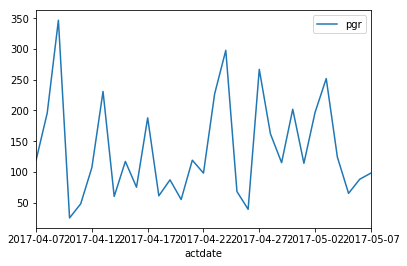

In [75]:
player_table = pd.DataFrame({'id': ['00371a21a9']})
res = pd.merge(player_table, dau_pact, on=['id'], how='left')
#print(res)
res = res.drop(['crystals', 'store_enters', 'm_quests', 'quest', 
                'revenue', 'transactions', 'country', 'clusters'], axis='columns')
res = res.groupby(['actdate'], as_index=False).sum()
res = res.set_index('actdate')
res = res.sort_index(0)
res = res.reset_index()
print(res)
first_day = res['actdate'][0]
m_later_day = pd.date_range(first_day, periods=31, freq='D').date[-1]
print(first_day, str(m_later_day))
new_sample_df = res.set_index('actdate').loc[first_day:str(m_later_day)]
new_sample_df.plot()
plt.show()